# Lab 7

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle


###  Load the Labeled Faces in the Wild (LFW) dataset from Sciki

In [15]:
faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])

X = faces.data
y = faces.target
target_names = faces.target_names
n_samples, n_features = X.shape
n_classes = len(target_names)

## Class Balance

### Check Class Balance

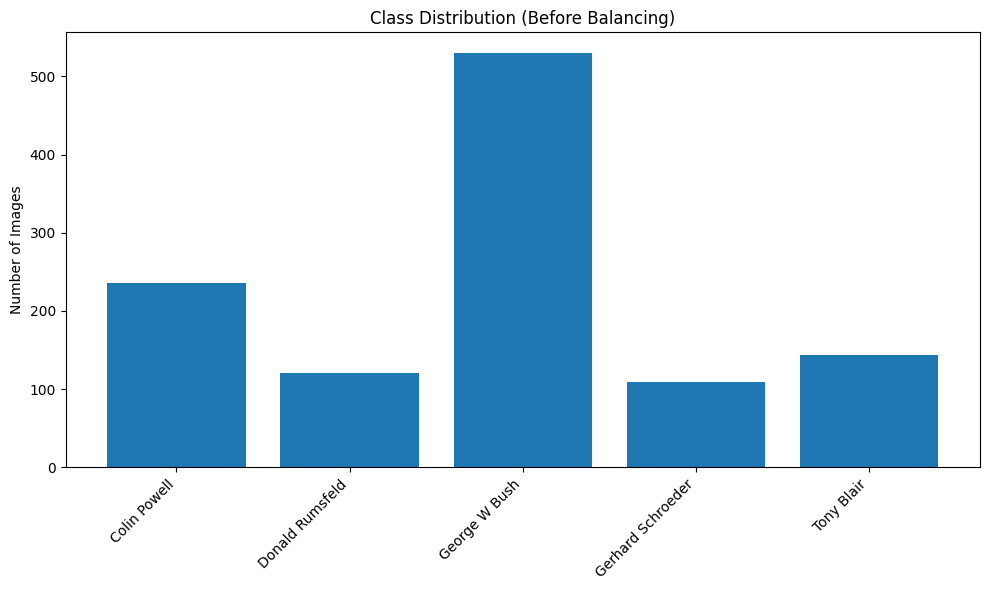

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
unique, counts = np.unique(y, return_counts=True)
ax.bar(target_names, counts)
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution (Before Balancing)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Balancing Strategy Implementation and Justification

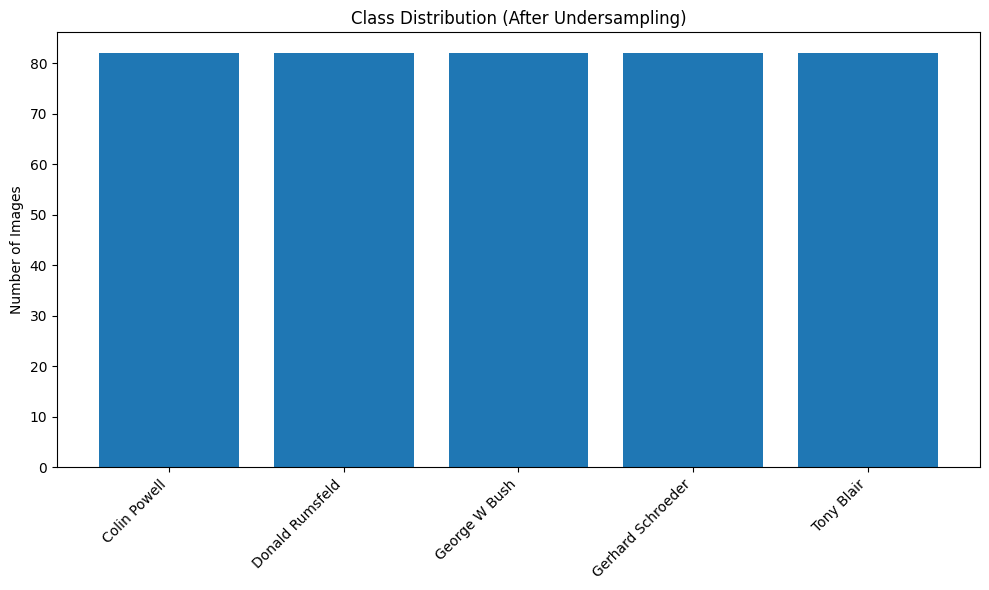

In [17]:
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

train_counts = Counter(y_train_raw)
min_samples = min(train_counts.values())

X_balanced = []
y_balanced = []

for label in np.unique(y_train_raw):
    idx = np.where(y_train_raw == label)[0]
    np.random.seed(42)
    selected_idx = np.random.choice(idx, min_samples, replace=False)
    X_balanced.append(X_train_raw[selected_idx])
    y_balanced.append(y_train_raw[selected_idx])

X_train = np.concatenate(X_balanced)
y_train = np.concatenate(y_balanced)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

fig, ax = plt.subplots(figsize=(10, 6))
unique_bal, counts_bal = np.unique(y_train, return_counts=True)
ax.bar(target_names, counts_bal)
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution (After Undersampling)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Intra-/Inter-Class Variance Comparison

In [18]:
def calculate_variance_metrics(X_data, y_data):
    metrics = {}
    class_indices = [np.where(y_data == i)[0] for i in np.unique(y_data)]

    centroids = np.array([X_data[i].mean(axis=0) for i in class_indices])
    overall_mean = X_data.mean(axis=0)
    inter_variance = np.sum(np.linalg.norm(centroids - overall_mean, axis=1)**2) / len(centroids)
    metrics['Inter-Class Variance'] = inter_variance

    intra_variance_list = []
    for i, idx in enumerate(class_indices):
        intra_variance_list.append(np.sum(np.linalg.norm(X_data[idx] - centroids[i], axis=1)**2) / len(idx))
    metrics['Intra-Class Variance (Mean)'] = np.mean(intra_variance_list)

    return metrics

print("--- Variance Before Balancing (Full Training Data) ---")
metrics_before = calculate_variance_metrics(X_train_raw, y_train_raw)
print(metrics_before)

print("\n--- Variance After Balancing (Undersampled Training Data) ---")
metrics_after = calculate_variance_metrics(X_train, y_train)
print(metrics_after)

# Discussion:
# The intra-class variance (spread within a class) should remain relatively stable or decrease slightly
# because undersampling removes outlier-like samples from large classes.
# The inter-class variance (distance between class centers) might change slightly due to the shift
# in the overall mean and the centroids of the undersampled classes.

--- Variance Before Balancing (Full Training Data) ---
{'Inter-Class Variance': np.float32(2.9920514), 'Intra-Class Variance (Mean)': np.float32(61.553307)}

--- Variance After Balancing (Undersampled Training Data) ---
{'Inter-Class Variance': np.float32(2.8555648), 'Intra-Class Variance (Mean)': np.float32(62.32781)}


## Linear SVM Baseline

### Grid Search and Reporting

Training Time: 1.22 seconds
Best C parameter: 0.2

Accuracy (Best C): 0.8105

Confusion Matrix:
                   Colin Powell  Donald Rumsfeld  George W Bush  \
Colin Powell                 51                1              4   
Donald Rumsfeld               2               26              2   
George W Bush                 9                9            107   
Gerhard Schroeder             0                1              1   
Tony Blair                    1                3              3   

                   Gerhard Schroeder  Tony Blair  
Colin Powell                       1           2  
Donald Rumsfeld                    0           0  
George W Bush                      3           5  
Gerhard Schroeder                 23           2  
Tony Blair                         5          24  


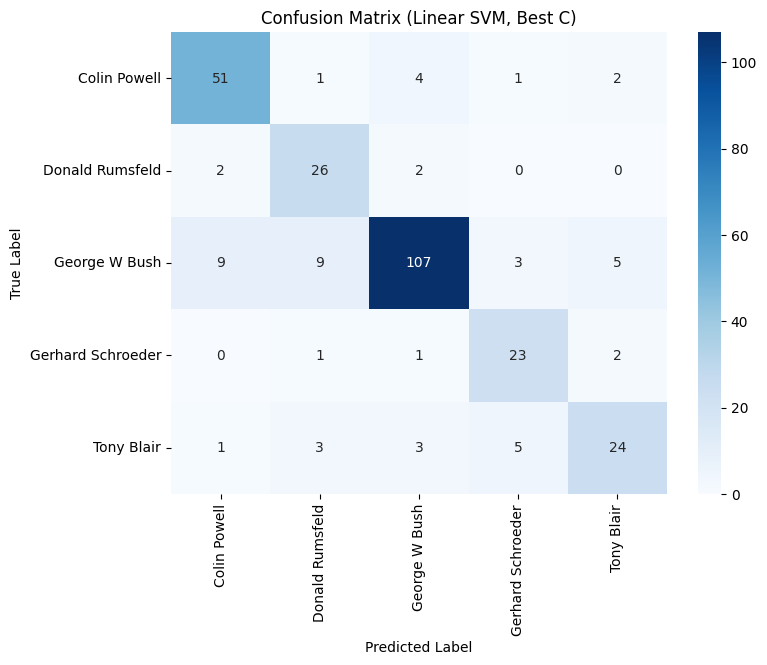

In [36]:
param_grid = {'C': [0.01, 0.1,0.2,0.3, 0.5,1, 10]}
clf = SVC(kernel='linear', class_weight='balanced', random_state=42)

grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

start_time = time.time()
grid.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Best C parameter: {grid.best_params_['C']}")

best_linear_clf = grid.best_estimator_
y_pred = best_linear_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy (Best C): {accuracy:.4f}")
print("\nConfusion Matrix:")

conf_mat_df = pd.DataFrame(conf_mat, index=target_names, columns=target_names)
print(conf_mat_df)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Linear SVM, Best C)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Explanation of $C$

The hyperparameter $C$ in SVM controls the trade-off between maximizing the margin (simplicity) and minimizing the training error (accuracy).
- Small $C$ (Weak Regularization): Allows for a wider (softer) margin and more misclassification of training samples. The model prioritizes finding a large separation boundary, leading to a simpler, more generalized model, which helps prevent overfitting.
- Large $C$ (Strong Regularization): Forces a tighter (harder) margin and penalizes misclassification errors heavily. The model tries to classify all training points correctly, increasing the risk of overfitting but potentially achieving higher training accuracy.

Relevance to Facial Recognition:

In the LFW dataset, faces of the same person (intra-class) can have high variability (different poses, lighting, expressions), and faces of different people (inter-class) can look similar (e.g., similar facial structures). This means the data is not perfectly linearly separable.
- A moderate $C$ is typically optimal, allowing a soft margin to ignore noisy or outlier facial images (e.g., an unusually lit or posed photo) that would otherwise skew the decision boundary.
- A very high $C$ would lead the linear SVM to overfit to these noisy images, making the model perform poorly on the unseen test set because the tight boundary wouldn't generalize to new poses or lighting conditions.

## Kernel Experiments

### Evaluate Various Kernels

In [37]:
kernels = ['poly', 'rbf', 'sigmoid']
kernel_results = {}

for k in kernels:
    start_time = time.time()

    clf = SVC(kernel=k, C=0.2, gamma='scale', random_state=42)
    clf.fit(X_train, y_train)
    end_time = time.time()

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    kernel_results[k] = {'Accuracy': accuracy, 'Time': end_time - start_time}

print("Kernel Evaluation Results")
print(pd.DataFrame(kernel_results).T)

Kernel Evaluation Results
         Accuracy      Time
poly     0.800000  0.160913
rbf      0.529825  0.243277
sigmoid  0.214035  0.239045


### Learning Curves and Hyperparameter Sensitivity (RBF Kernel)

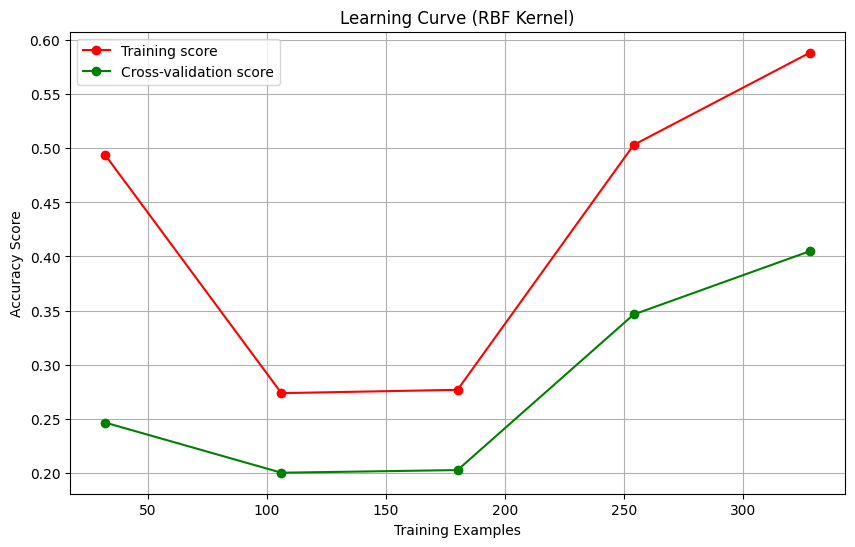

In [38]:
train_sizes, train_scores, test_scores = learning_curve(
    SVC(kernel='rbf', C=0.2, gamma='scale', random_state=42),
    X_train, y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve (RBF Kernel)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()